# **Recommendations with IBM**

In this notebook, I apply recommendation system techniques to real data from the IBM Watson Studio platform. The goal is to explore different methods for making recommendations that can be adapted to various scenarios.

I have structured this notebook following a logical workflow, starting with exploratory data analysis and then implementing multiple recommendation approaches. These include rank-based recommendations, user-user collaborative filtering, and matrix factorization. Additionally, I have included a section on content-based recommendations as an extra step.

## Table of Contents

**I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)**  
**II. [Rank-Based Recommendations](#Rank)**  
**III. [User-User Collaborative Filtering](#User-User)**  
**IV. [Content-Based Recommendations (Extra)](#Content-Recs)**  
**V. [Matrix Factorization](#Matrix-Fact)**  
**VI. [Additional Insights & Conclusion](#conclusions)**  

Now, I'll begin by importing the necessary libraries and loading the dataset.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [79]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


# **Part I: Exploratory Data Analysis**  

In this project, the dataset has been examined using descriptive statistics to gain insights into user interactions with articles.  

#### **User Interaction Distribution**  

To understand the distribution of user interactions with articles, both visualizations and statistical summaries have been used. This analysis provides a clear view of how frequently users engage with different articles.

In [80]:
# The median and maximum number of user-article interactions have been calculated in below.

median_val = df.groupby('email')['article_id'].count().median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = df.groupby('email')['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is 364.

#### **Removing Duplicate Articles** ####

To ensure data integrity, duplicate articles in the **df_content** dataframe have been identified and removed.

In [81]:
# Find and explore duplicate articles
df_content[df_content.duplicated('article_id', keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [82]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

#### **Dataset Overview: Unique Counts and Interactions**  

The following analysis has been conducted to gain insights into the dataset:  

- **(a)** The number of unique articles that have interactions with users.  
- **(b)** The total number of unique articles in the dataset (whether they have any interactions or not).  
- **(c)** The number of unique users in the dataset, excluding null values.  
- **(d)** The number of user-article interactions in the dataset.  

In [83]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

#### **Identifying the Most Viewed Article**  

The most viewed `article_id` has been determined, along with the number of times it was viewed.  

Additionally, after discussions with company leaders, the `email_mapper` function has been confirmed as a reasonable approach for mapping users to unique IDs. A small number of null values were identified, and it was concluded that these likely belong to a single user, as reflected in the function implementation below.

In [84]:
df['email'].fillna('NaN_category', inplace=True) # filling the null values of the email column  with 'NaN_category' 
most_viewed_article_id = str(df.groupby('article_id')['email'].count().nlargest(1).index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id')['email'].count().nlargest(1).iloc[0] # The most viewed article in the dataset was viewed how many times?

In [85]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [86]:

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>  

In this section, rank-based recommendations have been implemented. Unlike traditional rating-based systems, this dataset does not include explicit user ratings for articles. Instead, interactions are used as a measure of popularity.  

Since there is no indication of whether users liked or disliked an article, popularity is determined solely by the number of interactions an article has received.  

#### **Top Articles by Interaction Count**  

A function has been implemented to return the **n** most popular articles, ranked by the highest number of interactions. The function has also been tested to ensure accuracy.  

In [87]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = []
    for i in get_top_article_ids(n, df=df):
        top_articles.append(df.loc[df['article_id']==i, 'title'].iloc[0])
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('article_id')['user_id'].count().nlargest(n).index)
    
    return top_articles # Return the top article ids

In [88]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [89]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>  

In this section, user-user collaborative filtering has been implemented by restructuring the **df** dataframe into a user-item matrix.  

#### Matrix Structure: 
- Each **user** appears in a single row.  
- Each **article** is represented as a unique column.  
- If a user has interacted with an article, a value of **1** is assigned at the intersection of the user-row and article-column (It does not matter how many times a user has interacted with the article).  
- If no interaction has occurred, a **0** is assigned.  

The function below has been designed to transform the dataset into this format. Tests have been conducted to ensure the structure aligns with expectations.

In [90]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [91]:
## Tests:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


#### **Identifying Similar Users**  

A function has been implemented to identify and return an ordered list of the most similar users to a given `user_id`, ranked from most to least similar.  

#### Methodology:  
- The similarity between users is computed using the **dot product** of their interaction vectors, as the dataset contains binary values (1 for interaction, 0 for no interaction).  
- The provided `user_id` is excluded from the results since a user is always most similar to themselves.  

The function has been tested to ensure correctness and expected behavior.

In [92]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    dot_product  = {}
    # compute similarity of each user to the provided user
    for i in list(user_item.index):
        dot_product[i] = user_item.loc[user_id].dot(user_item.loc[i])
        
    # sort by similarity
    sorted_dict = dict(sorted(dot_product.items(), key=lambda item: item[1], reverse=True))
    
    # create list of just the ids
    most_similar_users = list(sorted_dict.keys())
    
    # remove the own user's id
    most_similar_users.remove(user_id) 
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [93]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


#### **Generating User-Based Recommendations**  

With the function for identifying similar users in place, the next step is to use these similarities to recommend articles.  

#### Recommendation Approach:  
- The most similar users are identified based on interaction patterns.  
- Articles that the similar users have interacted with, but the target user has not, are selected as recommendations.  

The functions below have been implemented to generate personalized article recommendations for each user.  

In [94]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    if not isinstance(article_ids, list):
        article_ids = [article_ids]
    
    article_names = []
    for i in article_ids:
        i = float(i)
        article_n = df.loc[df['article_id']==i, 'title'].iloc[0]
        if len(article_n):
            article_names.append(article_n)
                
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = list(set([i[1] for i in user_item.loc[user_id].index[user_item.loc[user_id] == 1].tolist()]))
    
    article_names = []
    
    for i in article_ids:
        filtered_df = df.loc[df['article_id'] == i, 'title'].values
        if len(filtered_df) > 0:
              article_names.append(filtered_df[0])
    article_ids = [str(x) for x in article_ids]
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id, user_item=user_item)
    article_read = get_user_articles(user_id, user_item=user_item)[0]
    recs = []
    n=0
    for u in similar_users:      
        rec_id, _ = get_user_articles(u, user_item=user_item)
        #the articles that have not been read by the user
        new_articles = [i for i in rec_id if i not in article_read]
        for r in new_articles:
            if n<m and r not in recs:
                recs.append(r)
                n+=1
                
    return recs # return your recommendations for this user_id    

In [95]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'shaping data with ibm data refinery',
 'timeseries data analysis of iot events by using jupyter notebook',
 'data science platforms are on the rise and ibm is leading the way',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'a tensorflow regression model to predict house values',
 'deep forest: towards an alternative to deep neural networks']

In [96]:
# Test your functions here
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


#### **Enhancing Consistency in User-Based Recommendations**  

To improve the consistency of the **user_user_recs** function, the following refinements have been made:  

- When selecting users with the same similarity score, preference is given to users with the highest total article interactions.  
- When selecting recommended articles, priority is given to those with the most total interactions, ensuring alignment with the ranking produced by the **top_articles** function.  

These improvements enhance the reliability and relevance of the recommendations.

In [98]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    dot_product  = {}
    # compute similarity of each user to the provided user
    for i in list(user_item.index):
        dot_product[i] = [user_item.loc[user_id].dot(user_item.loc[i]) ,
                          df.loc[df['user_id']==i]['article_id'].count()]
        
    # sort by similarity
    sorted_dict = dict(sorted(dot_product.items(), key=lambda x: (x[1][0], x[1][1]), reverse=True))
    
    # remove the own user's id
    del sorted_dict[user_id] 
    
    # Convert dictionary to list of dictionaries
    data = [{'neighbor_id': k, 'similarity': v[0], 'num_interactions': v[1]} for k, v in sorted_dict.items()]

    # Create DataFrame
    neighbors_df = pd.DataFrame(data)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    article_interactions = df.groupby('article_id').count()['user_id']   
    recs = []
    n=0
    # Grouping articles by interaction count
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    for u in neighbors_df['neighbor_id']:
        
        # List of article id values present in user, but not in input user_id
        new_recs = [float(i) for i in get_user_articles(u)[0] if i not in get_user_articles(user_id)[0]] 
        
        recs_to_add = list(article_interactions.loc[new_recs].sort_values(ascending=False).index)
        for re in recs_to_add:
            if n<m:
                recs.append(re)
                n+=1
            else:
                break
        if n>=m:
            break
    
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names

In [99]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


#### **Validating the Recommendation System**  

Using the implemented functions, the dictionary below has been populated with the correct values. The results have been tested to ensure consistency with the expected solution.  

The code used to generate each value is provided below, following the comments in the notebook.

In [100]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item)['neighbor_id'][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

In [101]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


#### **Handling Recommendations for New Users**  

For a new user with no prior interactions, collaborative filtering methods cannot be applied since there is no interaction history to find similar users. Instead, the **rank-based recommendation** approach can be used, where the most popular articles (those with the highest total interactions) are recommended.  

#### **Alternative Approach for Better Recommendations:**  
A more effective method for new users could involve **content-based recommendations**. This approach would analyze article metadata (such as keywords, topics, or categories) and recommend articles based on the user's stated preferences or browsing behavior. Additionally, a **hybrid recommendation system** that combines popularity-based and content-based methods could improve personalization while avoiding the cold-start problem.

### **Recommendation Strategies for New Users**  

The **rank-based recommendation** approach discussed earlier is applicable to new users, as it suggests the most-read articles. This method is particularly effective when the user base shares similar interests, increasing the likelihood of engagement with popular content.  

However, there are additional strategies that can enhance recommendations for new users:  

- **Recommend Trending Articles:**  
  If articles have a temporal nature, recommending trending content (based on a defined metric for "trending") can provide more relevant suggestions that align with current interests.  

- **Request Interest List from Users:**  
  Many services address the cold-start problem by allowing users to select topics of interest upon sign-up. Based on these selections, personalized recommendations can be made by suggesting the most relevant articles.  

By combining these approaches, recommendations for new users can be made more effective and tailored to their preferences.  

#### **Top 10 Recommended Articles for a New User**  

Using the previously implemented functions, the top 10 recommended articles for a new user have been generated. Since the user has no prior interactions, the **rank-based recommendation system** is applied, suggesting the most popular articles based on overall interaction counts.  

The results have been tested to ensure consistency with expected recommendations.

In [102]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10, df=df)] # Your recommendations here



In [103]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### **Part IV: Content-Based Recommendations (Optional)**  

An alternative approach to generating recommendations is to rank articles based on their relevance to a specific term or topic. Content-based recommendations can be derived from various fields such as `doc_body`, `doc_description`, or `doc_full_name`, as each contains meaningful content-related information.  

#### **Building a Content-Based Recommender**  
A function has been implemented to provide recommendations based on content similarity. Since there are multiple ways to approach this method, there is no single correct answer, allowing for flexibility in implementation.

In [104]:
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


In [105]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [106]:
def make_content_recs(search_term, df_content, num_recommendations = 5):
    '''
    Recommends articles based on a given search term by calculating the relevance of the term in each article's content.
    
    INPUT:
    
    search_term (str): The term to search for in the articles.
    df_content (DataFrame): DataFrame containing the content data with columns 'doc_body', 'doc_description', 
                            'doc_full_name', and 'article_id'.
    OUTPUT:
    
    list of int: A list of article IDs recommended based on their relevance to the search term, 
                 sorted by relevance score in descending order.
    '''
    
    # Combine relevant columns into a single column for text processing
    df_content['combined_content'] = df_content['doc_body'] + ' ' + df_content['doc_description'] + ' ' + df_content['doc_full_name']
    
    # Convert all text to lowercase to make the search case-insensitive
    df_content['combined_content'] = df_content['combined_content'].str.lower()
    
    # Handle missing values
    df_content['combined_content'] = df_content['combined_content'].fillna('')
    
    # Calculate relevance scores based on how many times the search term appears in each article
    df_content['relevance_score'] = df_content['combined_content'].apply(lambda x: x.count(search_term.lower()))
    
    # Sort articles by relevance score in descending order
    df_content = df_content.sort_values(by='relevance_score', ascending=False)
    
    # Return a list of article IDs ranked by relevance score
    recommended_article_ids = df_content['article_id'].head(num_recommendations).tolist()
    
    return recommended_article_ids

In [107]:
# Step 1: Input Preparation
search_term = "Python"
num_recommendations = 10
# Step 2: Call the Function
recommended_articles = make_content_recs(search_term, df_content, num_recommendations)

# Step 3: Get Recommendations
print("Recommended article IDs based on the search term '{}':".format(search_term))
print(recommended_articles)

Recommended article IDs based on the search term 'Python':
[426, 906, 494, 768, 710, 508, 1014, 1017, 1006, 941]


### **Summary of the Content-Based Recommendation System**  

With the content-based recommendation system in place, the following section provides a summary of its functionality. The approach used is discussed, along with possible improvements that could enhance its performance. Additionally, any unique aspects of the implemented method are highlighted.  

The system processes textual content by merging multiple columns (`doc_body`, `doc_description`, and `doc_full_name`) into a single column for analysis. To ensure case-insensitive searches, all text is converted to lowercase. Missing values are handled by replacing them with empty strings.  

To determine relevance, the system calculates a relevance score for each article based on the frequency of the search term within the combined content of the article. Articles are then ranked in descending order according to their relevance scores. Finally, the system returns a list of article IDs sorted by relevance, with the number of recommendations limited to a specified value.

#### Possible Improvements:

**Feature Engineering:** Additional feature engineering techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings could be employed to better represent the content and capture semantic similarities between articles.

**Text Preprocessing:** More sophisticated text preprocessing techniques like stemming, lemmatization, or removing stopwords could be applied to improve the quality of the content representation.

### **Generating Content-Based Recommendations**  

The content-based recommendation system has been used to generate recommendations for the scenarios outlined in the comments below. Since content-based filtering allows for multiple approaches, there is no single correct answer for these recommendations.  

In [108]:
# Creating a new DataFrame with article_id as index

relevant_columns = ['doc_description', 'doc_full_name', 'article_id']
df_relevant = df_content[relevant_columns]

# Creating a new DataFrame with articleUnderlineID as index
df_new = pd.DataFrame(index=df_relevant['article_id'])

# Iterating over rows to populate the DataFrame with 0s and 1s
for index, row in df_relevant.iterrows():
    article_id = row['article_id']
    
    doc_description = str(row['doc_description']) if not pd.isnull(row['doc_description']) else ''
    doc_full_name = str(row['doc_full_name']) if not pd.isnull(row['doc_full_name']) else ''
    
    text = doc_description + ' ' + doc_full_name
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    words = set(text.split())
    words = [w for w in words if w not in stopwords.words("english")]
    
    
    # Updating the DataFrame with 1s where the words are present
    for word in words:
        if word in df_new.columns:
            df_new.at[article_id, word] = 1
        else:
            df_new[word] = 0
            df_new.at[article_id, word] = 1

# Filling NaN values with 0s
df_new.fillna(0, inplace=True)

In [109]:
df_new.head()

,real,time,malfunctioning,iot,analytics,python,readings,detect,sensors,bad,...,regimes,discriminative,classifier,nicholas,hould,implementing,jean,loaded,ides,kernels
article_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:

def recommend_for_new_user(df, num_recommendations=5):
    # Simply recommend the most popular articles
    recommended_articles = [str(i) for i in get_top_article_ids(num_recommendations, df=df)]
    return recommended_articles

def recommend_articles_dot_product(article_id, df_new, num_recommendations=10):
    # Select the vector representing the input article
    article_vector = df_new.loc[article_id].values.reshape(1, -1)
    
    # Compute dot product between the input article and all other articles
    dot_products = df_new.values.dot(article_vector.T)
    
    # Create a DataFrame to store article IDs and their corresponding dot products
    dot_products_df = pd.DataFrame(dot_products, index=df_new.index, columns=['dot_product'])
    
    # Sort the DataFrame by dot products in descending order
    dot_products_df = dot_products_df.sort_values(by='dot_product', ascending=False)
    
    # Exclude the input article itself
    dot_products_df = dot_products_df.drop(index=article_id)
    
    # Get the top N recommended article IDs
    recommended_article_ids = dot_products_df.head(num_recommendations).index.tolist()
    
    return recommended_article_ids



In [111]:
# make recommendations for a brand new user

recommendations_for_new_user = recommend_for_new_user(df, 10)
print("Recommendations for a brand new user:", recommendations_for_new_user)

# make a recommendations for a user who only has interacted with article id '1427.0'

recommendations_for_interacted_user = [str(i) for i in recommend_articles_dot_product(1027.0, df_new, num_recommendations=10)]
print("Recommendations for a user who interacted with article '1427.0':", recommendations_for_interacted_user)

Recommendations for a brand new user: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
Recommendations for a user who interacted with article '1427.0': ['231', '1028', '902', '650', '56', '325', '33', '941', '345', '938']


### **Part V: Matrix Factorization**  

In this section, matrix factorization is used to generate article recommendations for users on the IBM Watson Studio platform.  

#### **Setting Up the User-Item Matrix**  
The user-item matrix created earlier in Part III has been utilized as the foundation for this approach. The following step ensures that everything is properly set up for the implementation of matrix factorization-based recommendations.  

In [112]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [113]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Applying Singular Value Decomposition (SVD)**  

In this scenario, **Singular Value Decomposition (SVD)** from NumPy has been applied to the user-item matrix to generate recommendations.  

#### **Key Differences from Previous Implementations:**  
Unlike in the lesson, where explicit user ratings were available, this dataset only contains implicit feedback—whether a user has interacted with an article or not. As a result, SVD is applied to a binary interaction matrix rather than a numerical rating system, which influences how recommendations are derived.  

In [114]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

##### **Here beacause we just have 0 and 1 values indicating whether a user has read an article or not, so there is no Nan value. Thererfore, we can perform SVD without any error and there is no need to use FunkSVD to overcome that shortcomming .**

#### **Selecting the Optimal Number of Latent Features**  

Determining the appropriate number of latent features is a crucial step in matrix factorization. As the number of latent features increases, the error rate in predicting the **1s and 0s** in the user-item matrix tends to decrease.  

By running the following cell, the relationship between the number of latent features and prediction accuracy is analyzed, providing insights into how accuracy improves with more latent features.

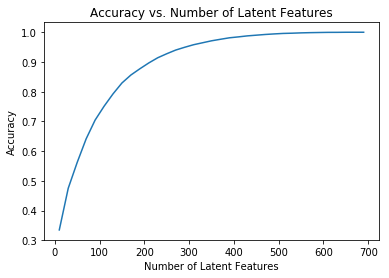

In [115]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

##### **Evaluating the Impact of Latent Features on Recommendation Accuracy**  

While increasing the number of latent features helps improve the ability to predict **1s and 0s** in the user-item matrix, it does not necessarily indicate that the recommendations generated are meaningful. A better approach is to **split the dataset into training and test sets** and evaluate how well the model generalizes.  

Using the dataset split below, the impact of different numbers of latent features on accuracy is analyzed. Additionally, the following key questions are addressed:  

- **How many users in the test set can we make predictions for?**  
- **How many users face the cold-start problem, making predictions impossible?**  
- **How many articles in the test set can we make predictions for?**  
- **How many articles are affected by the cold-start problem, preventing predictions?**  

By answering these questions, the limitations and effectiveness of matrix factorization in handling new users and articles are assessed.

In [116]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user_item matrices for train and test sets    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    # get the indices of the train and test sets
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_matrix.columns)
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [117]:
#'How many users in the test set are we not able to make predictions for because of the cold start problem?'
len( set(test_idx) - set(list(user_item_train.index)))

662

In [118]:
#'How many users in the test set we have
len(set(test_idx))

682

In [119]:
#'How many users can we make predictions for in the test set?'
len(set(test_idx)) - (len( set(test_idx) - set(list(user_item_train.index))))

20

In [120]:
#'How many articles can we make predictions for in the test set?'
len(set([i[1] for i in list(user_item_test.columns)]))

574

In [121]:
#'How many articles in the test set are we not able to make predictions for because of the cold start problem?'
set([i[1] for i in list(user_item_test.columns)]) - set([i[1] for i in list(user_item_train.columns)])

set()

In [122]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


### **Applying SVD to the Training Dataset and Evaluating Prediction Accuracy**  

Using the **user_item_train** dataset, the **U, S, and V^T** matrices have been derived through **Singular Value Decomposition (SVD)**. The next step is to identify the subset of rows (users) in the **user_item_test** dataset for whom predictions can be made based on this matrix decomposition.  

To determine the optimal number of latent features, different values are tested, and accuracy is evaluated on the test data. This analysis builds upon the previous steps, integrating insights from questions 2 to 4 to assess how well SVD performs in making meaningful recommendations.  

In [123]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

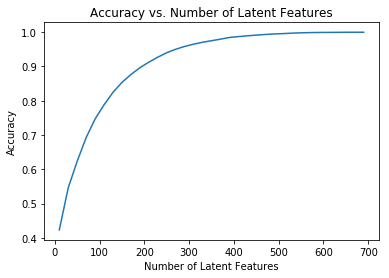

In [124]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [125]:
def predict_rating(user_id, user_item_train, num_latent_feats = 400):
    
    # Fit SVD on the user_item_train matrix
    u_train, s_train, vt_train = np.linalg.svd(user_item_train)

    # Restructure with 400 latent features
    s_new, u_new, vt_new = np.diag(s_train[:num_latent_feats]), u_train[:, :num_latent_feats], vt_train[:num_latent_feats, :]

    u_user = u_new[user_id -1 , :]
    
    # Take dot product to get the estimated user-item matrix
    user_item_est = np.around(np.dot(np.dot(u_user, s_new), vt_new))
    return user_item_est
    

In [126]:
# Compute the accuracy for our prediction

# users that we can make predictions for in the test set
user_20 = set(test_idx) - ( set(test_idx) - set(list(user_item_train.index)))

sum_errs = []
for user in user_20:
    # making perdiction for users
    user_item_est = predict_rating(user, user_item_train, num_latent_feats = 400)

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train.loc[user_item_train.index==user].values[0], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs))) / user_item_est.shape[0]
    sum_errs.append(err)
    
accuracy = sum(sum_errs) / len(sum_errs)
print("Accuracy with {} latent features: {:.2f}%".format(accuracy, accuracy * 100))

Accuracy with 0.00021008403361344536 latent features: 0.02%


#### **Analysis of SVD Performance and Evaluating Recommendation Effectiveness**  

The results from the previous step provide insights into how well **Singular Value Decomposition (SVD)** performs in predicting user-article interactions. Based on these findings, the effectiveness of matrix factorization for making recommendations is assessed.  

To determine whether the recommendations generated by this and other methods improve user experience compared to the current system, the following approaches can be considered:  

- **A/B Testing:** Users can be randomly assigned to different recommendation systems to compare engagement metrics such as click-through rate (CTR) and time spent on recommended articles.  
- **User Feedback Surveys:** Collecting qualitative feedback from users can provide insights into whether they find the recommended articles relevant and valuable.  
- **Historical Data Comparison:** Analyzing whether users engage more with articles recommended by the system compared to organic browsing behavior can indicate the effectiveness of the model.  

By implementing these evaluation methods, the overall impact of the recommendation system on user experience can be better understood.  

### **Optimizing Recommendations Based on User Segments**  

To enhance the effectiveness of the recommendation system, users can be categorized into three distinct groups based on their interaction history:  

1. **New Users** – Users who have not interacted with any articles before.  
2. **Occasional Users** – Users who have engaged with some articles but do not have a clear pattern of interest.  
3. **Focused Users** – Users who have extensively read articles within a specific category.  

Based on these segments, different recommendation strategies can be applied:  

- **For New Users:**  
  - Suggest the most popular articles overall.  
  - Use unsupervised clustering to categorize articles and recommend the top article from each category.  
  - Implement a hybrid approach combining both methods for better results.  

- **For Occasional Users:**  
  - Recommend articles similar to those they have already read.  
  - Identify similar users and suggest articles based on their preferences.  
  - Conduct **A/B testing** to determine which approach (or combination) yields the best engagement.  

- **For Focused Users:**  
  - Suggest articles from categories closely related to their primary interests.  
  - Provide feedback to the content team, indicating areas where more content could be developed.  

Since the effectiveness of these approaches may vary across different user segments, experimentation and testing can be used to identify the most successful strategy for each group.  

#### **Extras**  

With the current implementation, additional enhancements can be made to further develop and deploy the recommendation system. Some potential next steps include:  

- Saving the generated recommendations for each user for future reference.  
- Developing a class to make new predictions dynamically and update recommendations as new interactions occur.  
- Building a **Flask app** to deploy the recommendation system, allowing users to receive recommendations in real-time.  

While these tasks go beyond the scope of this project, the concepts learned throughout the process provide a strong foundation for implementing these improvements.

In [127]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0